<a href="https://colab.research.google.com/github/sraeisi/Machine_Learning_Physics_Winter20/blob/master/Chpt4/NN_ModelEvaluationa%26Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
plt.style.use('seaborn-talk')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

import requests
import io

## GPU

In [0]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

tf.config.experimental.set_memory_growth(gpus[0] , True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data: Farsi Hand-written digits classification

In [0]:
'''
Let's import the Farsi digits (your assignment)
'''

url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Assignments/A3/X.npz'
s=requests.get(url, stream=True).content
X = np.load(io.BytesIO(s) )['arr_0']
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Assignments/A3/Y.npz'
s=requests.get(url, stream=True).content
Y = np.load(io.BytesIO(s) )['arr_0']

# X = np.load('X.npz')['arr_0']
# Y = np.load('Y.npz')['arr_0']


from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state = 0 )

In [0]:
print('Each image is of the form: {}'.format(X[0].shape ) )

Each image is of the form: (32, 32)


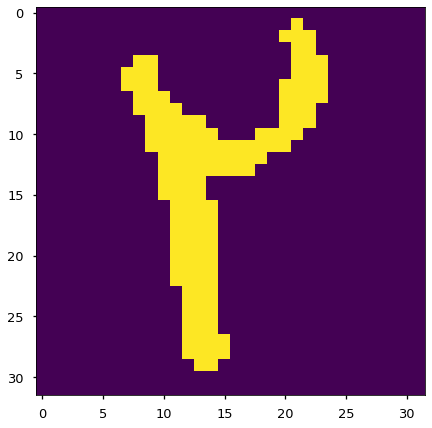

In [0]:
plt.imshow(X[20])

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

## Pytorch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [20]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        # self.conv1 = nn.Conv2d(1, 6, 3)
        # self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        # self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        # x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.log_softmax(x, dim=1)

        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


In [23]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999))

tensor([[-2.3116, -2.3463, -2.3377, -2.2692, -2.2687, -2.4167, -2.2904, -2.2556,
         -2.3332, -2.2114]], grad_fn=<LogSoftmaxBackward>)


In [0]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

## Fir the onehot encoding
enc = np.identity(10)

y_tr = torch.from_numpy(Y_train)#.float()
y_ts = torch.from_numpy(Y_test)#.float()

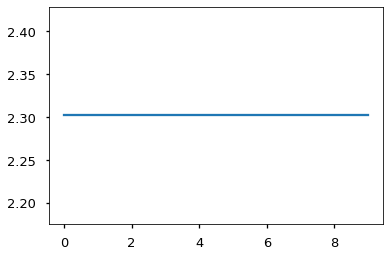

In [29]:
epochs = 10

#We also need to keep track of the loss. 
losses = []

for i in range(epochs):
    #Clear the previous gradients
    optimizer.zero_grad()
    
    #Precit the output for Given input
    y_pred = net.forward(x_tr)
    
    loss = F.nll_loss(y_pred, y_tr)
    losses += [loss]


    loss.backward()
    optimizer.step()
    
    
plt.plot(losses)

## Keras

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
# tf.config.experimental.set_memory_growth
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = False
# tf.config.gpu.set_per_process_memory_fraction(0.4)

from tensorflow import keras

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(X_train,Y_train, validation_split=0.25, epochs=5, batch_size=500)

Epoch 1/5
116/116 [==============================] - 1s 5ms/step - loss: 0.3529 - accuracy: 0.9008 - val_loss: 0.1685 - val_accuracy: 0.9532
Epoch 2/5
116/116 [==============================] - 0s 4ms/step - loss: 0.1364 - accuracy: 0.9620 - val_loss: 0.1270 - val_accuracy: 0.9643
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.1006 - accuracy: 0.9724 - val_loss: 0.1037 - val_accuracy: 0.9712
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0764 - accuracy: 0.9793 - val_loss: 0.0882 - val_accuracy: 0.9757
Epoch 5/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0614 - accuracy: 0.9836 - val_loss: 0.0795 - val_accuracy: 0.9771


In [0]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(Y_test, Y_predicted)
print(cm)

[[2518    0    0    1    0   13    1    2    1    0]
 [   0 2499    3    0    1    0    3    3    0    2]
 [   3   21 2382   38   23    0   15   10    1    7]
 [   1    0   59 2451   30    2    1    0    0    0]
 [   3   10   19   61 2563   20    9    5    2    0]
 [   7    4    1    2    4 2468    2    0    8    1]
 [   3    8    8    1    9    4 2541   12    2   20]
 [   4    4    2    2    4    5    4 2583    0    0]
 [   3    6    0    2    1    4    4    1 2518    9]
 [   0   19    3    0    3    1   26    0   14 2478]]


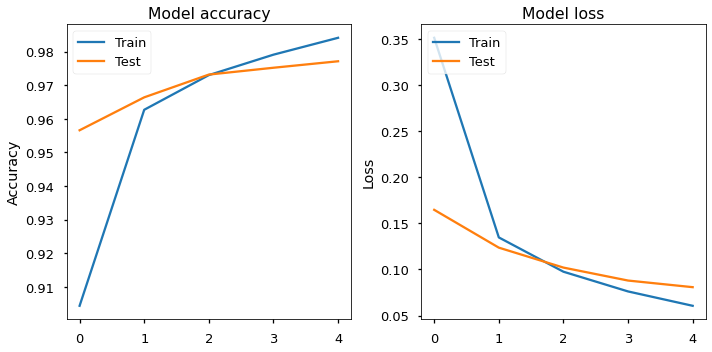

In [0]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [0]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

## We need to change the loss function for the one-hot encoding
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train,Y_train, validation_split=0.25, epochs=50, batch_size=500, verbose=1)

Train on 57573 samples, validate on 19191 samples
Epoch 1/50
57573/57573 [==============================] - 3s 57us/sample - loss: 0.3462 - accuracy: 0.9032 - val_loss: 0.1695 - val_accuracy: 0.9526
Epoch 2/50
57573/57573 [==============================] - 1s 22us/sample - loss: 0.1373 - accuracy: 0.9622 - val_loss: 0.1256 - val_accuracy: 0.9656
Epoch 3/50
57573/57573 [==============================] - 1s 21us/sample - loss: 0.1017 - accuracy: 0.9727 - val_loss: 0.1040 - val_accuracy: 0.9706
Epoch 4/50
57573/57573 [==============================] - 1s 22us/sample - loss: 0.0794 - accuracy: 0.9784 - val_loss: 0.0914 - val_accuracy: 0.9739
Epoch 5/50
57573/57573 [==============================] - 1s 20us/sample - loss: 0.0639 - accuracy: 0.9831 - val_loss: 0.0838 - val_accuracy: 0.9764
Epoch 6/50
57573/57573 [==============================] - 1s 23us/sample - loss: 0.0522 - accuracy: 0.9861 - val_loss: 0.0767 - val_accuracy: 0.9774
Epoch 7/50
57573/57573 [==============================] 

In [0]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
print(cm)


[[2521    0    1    0    0   14    0    0    0    0]
 [   0 2503    4    0    1    0    1    0    0    2]
 [   3    7 2448   22    9    0    6    3    0    2]
 [   1    0   51 2465   25    2    0    0    0    0]
 [   1    7   13   34 2614    8    7    4    1    3]
 [   8    1    1    3    7 2467    3    0    5    2]
 [   1    4    5    0    3    2 2573    3    1   16]
 [   5    3    3    0    3    3    4 2587    0    0]
 [   2    4    0    2    0    3    4    1 2519   13]
 [   1   11    1    0    1    0   13    0    6 2511]]


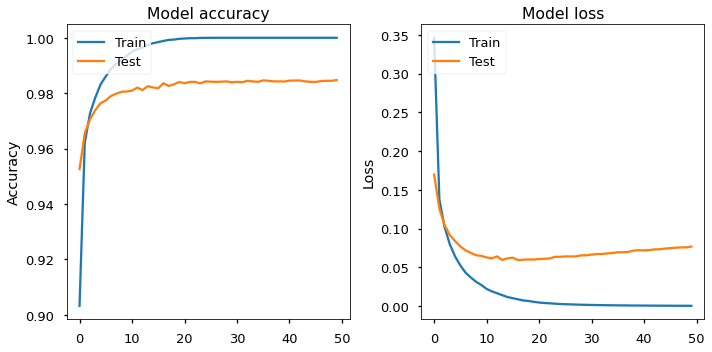

In [0]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Handling Overfitting


In [0]:
n_s = 100000
model.reset_states()
history_ovfit = model.fit(X_train[:n_s],Y_train[:n_s], 
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=10 , 
                          batch_size=256, 
                          verbose=1)

Train on 76764 samples, validate on 25588 samples
Epoch 1/10
76764/76764 [==============================] - 3s 36us/sample - loss: 1.3162e-04 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9883
Epoch 2/10
76764/76764 [==============================] - 3s 35us/sample - loss: 1.1761e-04 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9880
Epoch 3/10
76764/76764 [==============================] - 3s 35us/sample - loss: 1.0420e-04 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9882
Epoch 4/10
76764/76764 [==============================] - 3s 35us/sample - loss: 9.2805e-05 - accuracy: 1.0000 - val_loss: 0.0691 - val_accuracy: 0.9882
Epoch 5/10
76764/76764 [==============================] - 3s 34us/sample - loss: 8.0629e-05 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9882
Epoch 6/10
76764/76764 [==============================] - 3s 34us/sample - loss: 7.2546e-05 - accuracy: 1.0000 - val_loss: 0.0704 - val_accuracy: 0.9883
Epoch 7/10
76764/76764 [========

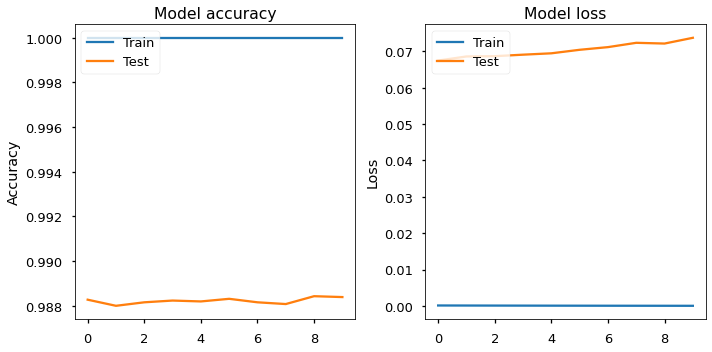

In [0]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit.history['accuracy'])
plt.plot(history_ovfit.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit.history['loss'])
plt.plot(history_ovfit.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [0]:
model_ovfit1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(100) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1)),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


model_ovfit1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_ovfit1.build([None, 2])
model_ovfit1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                1290      
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


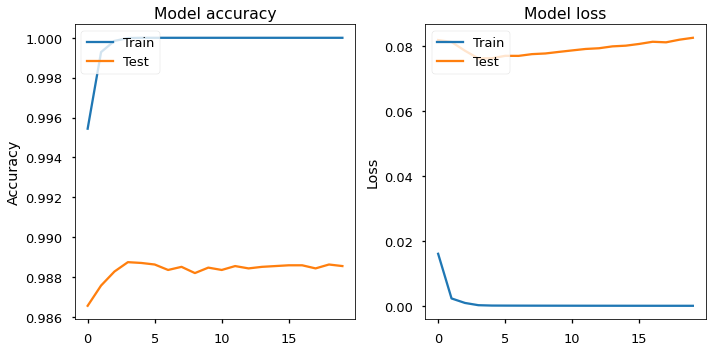

In [0]:
n_s = 1000000
history_ovfit1 = history_ovfit = model.fit(X_train[:n_s],Y_train[:n_s], 
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=20 , 
                          batch_size=256, 
                          verbose=0)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit1.history['accuracy'])
plt.plot(history_ovfit1.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit1.history['loss'])
plt.plot(history_ovfit1.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

Train on 10000 samples, validate on 25588 samples
Epoch 1/20
10000/10000 [==============================] - 2s 236us/sample - loss: 1.8359 - accuracy: 0.3484 - val_loss: 0.7569 - val_accuracy: 0.7778
Epoch 2/20
10000/10000 [==============================] - 1s 93us/sample - loss: 0.8987 - accuracy: 0.6955 - val_loss: 0.3726 - val_accuracy: 0.8953
Epoch 3/20
10000/10000 [==============================] - 1s 92us/sample - loss: 0.5750 - accuracy: 0.8193 - val_loss: 0.2642 - val_accuracy: 0.9175
Epoch 4/20
10000/10000 [==============================] - 1s 94us/sample - loss: 0.4461 - accuracy: 0.8654 - val_loss: 0.2237 - val_accuracy: 0.9327
Epoch 5/20
10000/10000 [==============================] - 1s 94us/sample - loss: 0.3611 - accuracy: 0.8942 - val_loss: 0.2062 - val_accuracy: 0.9388
Epoch 6/20
10000/10000 [==============================] - 1s 92us/sample - loss: 0.3220 - accuracy: 0.9049 - val_loss: 0.1902 - val_accuracy: 0.9440
Epoch 7/20
10000/10000 [==============================]

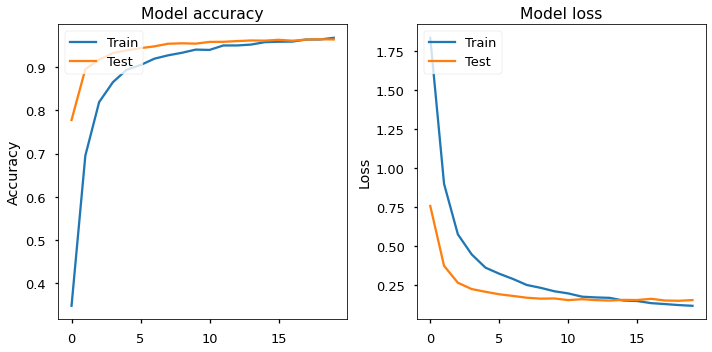

In [0]:
model_ovfit2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


model_ovfit2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ovfit2 = model_ovfit2.fit(X_train[:n_s],Y_train[:n_s], 
                                  validation_data = (X_test, Y_test),
#                                   validation_split=0.05, 
                                  epochs=20 , 
                                  batch_size=256, verbose=1)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit2.history['accuracy'])
plt.plot(history_ovfit2.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit2.history['loss'])
plt.plot(history_ovfit2.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Play with these models

## Full Pipeline

-- Preparing the dta

-- Cross-validation 

-- Parameter tuning 

-- 

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [0]:
def model_fn():
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [0]:
epch = 10
batch_sz = 500

from sklearn.model_selection import KFold
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True)


loss = []
acc = []
val_loss = []
val_acc = []

# cross validate:
for train_index, val_index in kf.split(X):
    model = model_fn()
    hist = model.fit(X[train_index], Y[train_index],
                     epochs=epch,
                     batch_size=500,
                     validation_data = (X[val_index], Y[val_index]),
                     verbose=0)
    loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    val_loss.append([hist.history['val_loss']])
    val_acc.append(hist.history['val_accuracy'])
    
loss = np.array(loss).reshape(n_folds, epch )    
acc = np.array(acc).reshape(n_folds, epch )       
val_loss = np.array(val_loss).reshape(n_folds, epch )      
val_acc  = np.array(val_acc).reshape(n_folds, epch )       

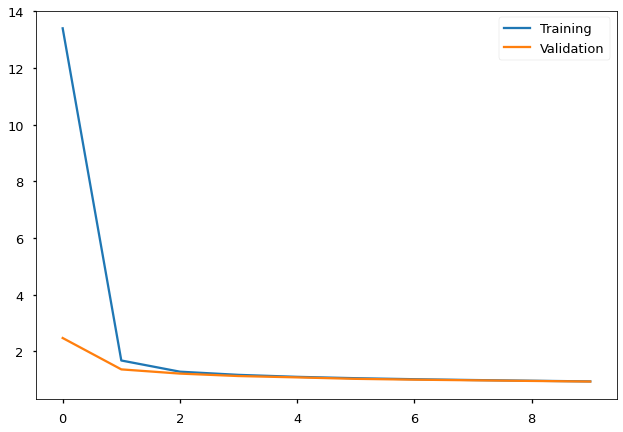

In [0]:
loss_m = loss.mean(axis=0)
loss_s = loss.var(axis=0)


val_loss_m = val_loss.mean(axis=0)
val_loss_s = val_loss.var(axis=0)

plt.plot(loss_m, label = 'Training')
plt.fill_between(range(len(loss_m)),loss_m-loss_s/2, loss_m+loss_s/2)
plt.plot(val_loss_m, label = 'Validation')
plt.fill_between(range(len(loss_m)),val_loss_m-loss_s/2, val_loss_m+loss_s/2)
plt.legend(loc=0)
plt.show()

In [0]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=1)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(ks_model, X, Y, cv=kfold)
print(results.mean())

Train on 92116 samples
Epoch 1/10
92116/92116 [==============================] - 8s 84us/sample - loss: 3.1624 - accuracy: 0.8503
Epoch 2/10
92116/92116 [==============================] - 7s 72us/sample - loss: 1.0461 - accuracy: 0.8778
Epoch 3/10
92116/92116 [==============================] - 7s 72us/sample - loss: 0.9377 - accuracy: 0.8873
Epoch 4/10
92116/92116 [==============================] - 7s 73us/sample - loss: 0.8698 - accuracy: 0.8949
Epoch 5/10
92116/92116 [==============================] - 7s 73us/sample - loss: 0.8269 - accuracy: 0.8990
Epoch 6/10
92116/92116 [==============================] - 7s 72us/sample - loss: 0.7911 - accuracy: 0.9015
Epoch 7/10
92116/92116 [==============================] - 7s 73us/sample - loss: 0.7632 - accuracy: 0.9046
Epoch 8/10
92116/92116 [==============================] - 7s 73us/sample - loss: 0.7417 - accuracy: 0.9064
Epoch 9/10
92116/92116 [==============================] - 7s 73us/sample - loss: 0.7218 - accuracy: 0.9091
Epoch 10/10
10

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

csv_logger = CSVLogger('training.log', append=True)
calls=[csv_logger, EarlyStopping(monitor='acc', patience=10), ModelCheckpoint('model_log', monitor='acc', save_best_only=True, mode='auto', period=1)]


In [0]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0  )
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0 )
results = cross_val_score(ks_model, X, Y, cv=kfold,
                      fit_params = {'callbacks': [csv_logger, history_logger]})
print(results.mean())


0.8827282786369324


In [0]:
import pandas as pd
df = pd.read_csv('training.log')
df.groupby('epoch').mean()

,accuracy,loss
epoch,,
0,0.791685,13.269427
1,0.865829,1.679507
2,0.871742,1.278126
3,0.875222,1.162926
4,0.877733,1.096090
5,0.879162,1.050194
6,0.881189,1.014766
7,0.883527,0.984274
8,0.884421,0.961510


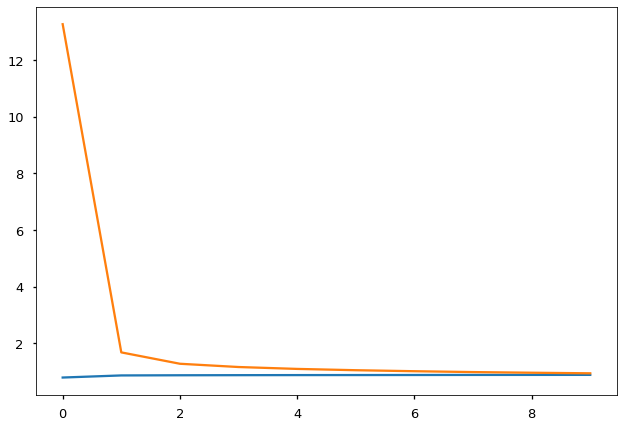

In [0]:
plt.plot(df.groupby('epoch').mean())

## Tuning

In [0]:
def model_fn(dense_layer_sizes, regularizations, dropouts, lr=.1):
    model = keras.Sequential() 
    
    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )
    
    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i], 
                                      activation=tf.nn.relu, 
                                      kernel_regularizer=keras.regularizers.l2(regularizations[i]) 
                                     ) )
        model.add(keras.layers.Dropout( dropouts[i] ) )
        
       
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
        
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    

    return model

mdl = model_fn([100, 30], [.001, .001], [.001, .001], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
__________________________________________________

In [0]:
def model_fn(dense_layer_sizes, lr=.1):
    model = keras.Sequential() 
    
    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )
    
    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i], 
                                      activation=tf.nn.relu #, 
                                      # kernel_regularizer=keras.regularizers.l2(regularizations[i]) 
                                     ) )
        # model.add(keras.layers.Dropout( dropouts[i] ) )
        
       
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
        
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    

    return model

mdl = model_fn([100, 30], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_542"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_542 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_498 (Dense)            (None, 100)               102500    
_________________________________________________________________
dense_499 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_500 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_________________________________________________________________


In [0]:
btch_size = 500
epch = 3
history = mdl.fit(X_train, Y_train, batch_size=btch_size, epochs=epch )

Epoch 1/3
154/154 [==============================] - 1s 3ms/step - loss: 1.2398 - accuracy: 0.7664
Epoch 2/3
154/154 [==============================] - 1s 3ms/step - loss: 0.2321 - accuracy: 0.9404
Epoch 3/3
154/154 [==============================] - 1s 3ms/step - loss: 0.1877 - accuracy: 0.9542


In [0]:
# Grid search over these:
dense_size_candidates = [(10, 40), (50) , (20) ]
# regularizations_candidates = [ (.01), (.01), (.001) ]
# dropouts_candidates = [  (.005), (.01), (.003) ]
lr_candidates = [.1]
# epch_list = [4, 10]
batch_size_candidates = 500

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
# from sklearn.model_selection import 

gs_classifier = KerasClassifier(model_fn, batch_size=500, epochs=5)


In [0]:
validator = GridSearchCV(gs_classifier,
                         param_grid={'dense_layer_sizes': dense_size_candidates,
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [3],
                                    #  'regularizations': regularizations_candidates,
                                    #  'dropouts': dropouts_candidates,
                                     'lr': lr_candidates},
                         scoring='neg_log_loss',
                         n_jobs= 1,  )
validator.fit(X_train, Y_train)

Epoch 1/3
123/123 [==============================] - 0s 3ms/step - loss: 1.6646 - accuracy: 0.3618
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.2692 - accuracy: 0.4843
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.1268 - accuracy: 0.5472
Epoch 1/3
123/123 [==============================] - 0s 4ms/step - loss: 1.6177 - accuracy: 0.3883
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.0026 - accuracy: 0.5998
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 0.8212 - accuracy: 0.6864
Epoch 1/3
123/123 [==============================] - 0s 3ms/step - loss: 1.5900 - accuracy: 0.3817
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.1025 - accuracy: 0.5609
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6166
Epoch 1/3
123/123 [==============================] - 0s 3ms/step - loss: 1.7747 - accuracy: 0.3355
Epoch 2/3


GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f64972b7518>,
             iid='deprecated', n_jobs=1,
             param_grid={'dense_layer_sizes': [(10, 40), 50, 20], 'epochs': [3],
                         'lr': [0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [0]:
print('The parameters of the best model are: ')
print(validator.best_params_)

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = validator.best_estimator_.model

The parameters of the best model are: 
{'dense_layer_sizes': (10, 40), 'epochs': 3, 'lr': 0.1}


In [0]:
best_model.save('best_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model/assets


## Try this for the particle identification problem.

In [36]:
import pandas as pd
url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )
 
'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [37]:
n_s = len(data)
targets = list(set(data['id']))
# mini_data = data.sample(n_s, axis=0, random_state=0)
# data['target'] = data['id'].apply(lambda x: targets.index(x)) 
data['id'] = pd.Categorical(data.id)
# data.drop('id',axis=1, inplace=True)

data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [0]:
from sklearn.model_selection import train_test_split
Y_oh = keras.utils.to_categorical(data.id.cat.codes, num_classes=4, dtype=int)
ind_to_keep = ['p', 'beta']
X = data[ind_to_keep].values

X_train, X_test, Y_train, Y_test = train_test_split( data[ind_to_keep], Y_oh, random_state=0)

In [40]:
Y_train.shape

(3750000, 4)